## CSC 580 AI II (Winter 2026) **HW\#5 RLHF** -- Start-up code

### **Simple_RLHF.ipynb** -- Simple implementation of Reinforcement Learning Human Feedback (RLHF)

### Students fill in the places indicated with "(*) TODO" (1-15). Sample outputs are baked in this notebook file but also in the html of this file

In [19]:
# ## Code piece to mount my Google Drive
# from google.colab import drive
# drive.mount("/content/drive") # my Google Drive root directory will be mapped here

In [20]:
# # Change the working directory to your own work directory (where the code file is).
# import os
# thisdir = '/content/drive/My Drive/CSC580_Winter2026/hw5_rlhf'
# os.chdir(thisdir)

# # Ensure the files are there (in the folder)
# !pwd

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification

In [22]:
# Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "gpt2"  # https://huggingface.co/openai-community/gpt2
MAX_LENGTH = 256
BATCH_SIZE = 8

print(f"Device: {device}")
print(f"Model: {MODEL_NAME}")

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME) # load from HuggingFace
tokenizer.pad_token = tokenizer.eos_token

Device: cuda
Model: gpt2


## Part 1: Supervised Fine-Tuning (SFT) of Policy Model

We use [databricks-dolly-15k](https://huggingface.co/datasets/databricks/databricks-dolly-15k) -- "an open source dataset of instruction-following records generated by thousands of Databricks employees in several of the behavioral categories outlined in the InstructGPT paper".




In [23]:
# %%
class SFTDataset:
    def __init__(self, sample_size=10000):
        print("Loading SFT dataset...")
        # Use a reasonable-sized instruction dataset
        dataset = load_dataset("databricks/databricks-dolly-15k", split="train")

        # Limit to sample_size
        sample_size = min(sample_size, len(dataset))
        dataset = dataset.select(range(sample_size))

        # Format for instruction following
        def format_example(example):
            return {
                'text': f"Instruction: {example['instruction']}\nContext: {example['context']}\nResponse: {example['response']}"
            }

        self.dataset = dataset.map(format_example, remove_columns=['instruction', 'context', 'response', 'category'])
        print(f"SFT dataset size: {len(self.dataset)}")

    def get_batch(self, batch_size=BATCH_SIZE):
        """Get batch for SFT training (by random sampling)"""
        indices = np.random.choice(len(self.dataset), batch_size, replace=False)
        texts = [self.dataset[int(i)]['text'] for i in indices]

        # Tokenize
        tokens = tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors="pt"
        )

        return tokens

In [24]:
# Function for sft training
def train_sft(num_steps=200):
    """Simple SFT training"""
    print("\n" + "="*50)
    print("STEP 1: SUPERVISED FINE-TUNING")
    print("="*50)

    # Load model -- CausalLM model (thus language modelling)
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
    model = model.to(device)

    # Ensure pad token is set for SFT model config
    if model.config.pad_token_id is None:
        model.config.pad_token_id = tokenizer.pad_token_id

    # Dataset
    dataset = SFTDataset(sample_size=5000)

    # Create an optimizer for the model
    # Use AdamW Optimizer with learning rate 2e-5
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

    # Training loop
    model.train()
    losses = []

    for step in range(num_steps):
        batch = dataset.get_batch(batch_size=BATCH_SIZE)
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass -- pass inputs and labels
        outputs = model(**batch, labels=batch['input_ids'])
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Keep track of the losses
        losses.append(loss.item())

        if step % 50 == 0:
            print(f"  Step {step}/{num_steps}: Loss={loss.item():.4f}")

    print("SFT training complete!")

    # Save the model
    model.save_pretrained("./sft_model")
    tokenizer.save_pretrained("./sft_model")

    return model

#----------------------------
# Train SFT model
sft_model = train_sft()


STEP 1: SUPERVISED FINE-TUNING


Loading weights: 100%|██████████| 148/148 [00:00<00:00, 556.00it/s, Materializing param=transformer.wte.weight]             


Loading SFT dataset...
SFT dataset size: 5000
  Step 0/200: Loss=5.2323
  Step 50/200: Loss=3.1394
  Step 100/200: Loss=2.0008
  Step 150/200: Loss=1.3132
SFT training complete!


Writing model shards: 100%|██████████| 1/1 [00:05<00:00,  5.35s/it]


## Part 2: Preference Dataset for Reward Modeling

We use [Anthropic/hh-rlhf](https://huggingface.co/datasets/Anthropic/hh-rlhf) -- a dataset containing "Human preference data about helpfulness and harmlessness".  It has columns "chosen" and "rejected".

For training, the default size of 8_000 instances, randomly chosen, are used.

In [25]:
# %%
class PreferenceDataset:
    def __init__(self, sample_size=10000):
        print("\nLoading preference dataset...")
        # Use Anthropic HH-RLHF dataset
        dataset = load_dataset("Anthropic/hh-rlhf", split="train")

        # Limit to sample_size
        sample_size = min(sample_size, len(dataset))
        dataset = dataset.select(range(sample_size))

        # Process examples
        processed_data = []
        for example in dataset:
            chosen = example['chosen']
            rejected = example['rejected']

            # Extract assistant responses (last part after "Assistant: ")
            # The format is: [human message]\n\nAssistant: [response]
            if "\n\nAssistant: " in chosen:
                chosen_response = chosen.split("\n\nAssistant: ")[-1] # Get the response part
                rejected_response = rejected.split("\n\nAssistant: ")[-1] # Same for rejected

                # Extract prompt (everything before assistant response)
                prompt = chosen.split("\n\nAssistant: ")[0]  # Get the prompt part


                if len(chosen_response) > 10 and len(rejected_response) > 10:
                    processed_data.append({
                        'prompt': prompt,
                        'chosen': chosen_response,
                        'rejected': rejected_response
                    })

        self.data = processed_data
        print(f"Preference dataset size: {len(self.data)}")

    def get_batch(self, batch_size=BATCH_SIZE):
        """Get batch of (prompt, chosen, rejected)"""
        indices = np.random.choice(len(self.data), batch_size, replace=False)
        batch = [self.data[int(i)] for i in indices]

        # Tokenize
        prompts = [item['prompt'] for item in batch]
        chosen_texts = [item['chosen'] for item in batch]
        rejected_texts = [item['rejected'] for item in batch]

        # Tokenize prompts
        prompt_tokens = tokenizer(
            prompts,
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH // 2,
            return_tensors="pt"
        )

        # Tokenize responses
        chosen_tokens = tokenizer(
            chosen_texts,
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH // 2,
            return_tensors="pt"
        )

        rejected_tokens = tokenizer(
            rejected_texts,
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH // 2,
            return_tensors="pt"
        )

        return prompt_tokens, chosen_tokens, rejected_tokens

#-------------------------------------------
# Create dataset
pref_dataset = PreferenceDataset(sample_size=8000)


Loading preference dataset...
Preference dataset size: 7731


## Part 3: Reward Model Training

Note that input text is first tokenized by the tokenizer, and a tensor of the token ids is created.  The remaining positions after the fixed length of tensor will be filled with pad_tokens, and an attention mask is created based on that (entry values 1 for in-sentences, 0 for padding).

For each instance, the reward model processes a pair: a chosen text and a rejected text.  Each one produces a reward score.  We examine the difference between the two scores then... (you figure out the rest).

For **training**, the poor model uses 30% of the randomly selected instances, while the good model uses 100% of the instances.

For **evaluation**, 30 instances for the poor model and 100 instances for the good models, both randomly chosen, are used.

In [26]:
# %%
class RewardModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Start from the pretrained model from HuggingFace (with classification head)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            MODEL_NAME,
            num_labels=1
        )

        # Ensure pad token is set
        if self.model.config.pad_token_id is None:
            self.model.config.pad_token_id = tokenizer.pad_token_id

    def forward(self, input_ids, attention_mask):
        return self.model(
            input_ids=input_ids,
            attention_mask=attention_mask
        ).logits.squeeze(-1)

    def compute_loss(self, chosen, rejected):
        chosen_rewards = self.forward(chosen['input_ids'], chosen['attention_mask'])
        rejected_rewards = self.forward(rejected['input_ids'], rejected['attention_mask'])

        # Implement the Bradley-Terry loss
        # The loss should encourage chosen_rewards > rejected_rewards
        # Use log sigmoid of the difference
        diff = chosen_rewards - rejected_rewards

        # Compute the Bradley-Terry loss
        loss = -F.logsigmoid(diff).mean() # mean over minibatch

        # accuracy is when diff is > 0 (and the mean over the list)
        accuracy = (diff > 0).float().mean()

        return loss, accuracy

#--------------------
def train_reward_model(train_fraction=1.0, name="Model"):
    """Train reward model with different quality levels"""
    model = RewardModel().to(device)

    # Create an optimizer for the reward model
    # Use Adam with learning rate 1e-5
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    print(f"\nTraining {name} reward model...")

    model.train()
    steps = int(100 * train_fraction)  # Adjust fraction based on desired quality

    # training using instances randomly chosen from preference data
    for step in range(steps):
        _, chosen, rejected = pref_dataset.get_batch(batch_size=BATCH_SIZE)

        # Move to device
        chosen = {k: v.to(device) for k, v in chosen.items()}
        rejected = {k: v.to(device) for k, v in rejected.items()}

        # Compute the loss using the reward model's compute_loss method 
        loss, accuracy = model.compute_loss(chosen, rejected)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 20 == 0:
            print(f"  Step {step}/{steps}: Loss={loss.item():.4f}")

    print("Reward model training complete!")
    model.eval()
    return model

#--------------------
print("\n" + "="*50)
print("STEP 2: REWARD MODEL TRAINING")
print("="*50)

#-----------------------------------------------
# Train two reward models with different quality
#-----------------------------------------------
poor_rm = train_reward_model(train_fraction=0.3, name="POOR")
good_rm = train_reward_model(train_fraction=1.0, name="GOOD")


STEP 2: REWARD MODEL TRAINING


Loading weights: 100%|██████████| 148/148 [00:00<00:00, 506.49it/s, Materializing param=transformer.wte.weight]             
GPT2ForSequenceClassification LOAD REPORT from: gpt2
Key          | Status  | 
-------------+---------+-
score.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.



Training POOR reward model...
  Step 0/30: Loss=0.8731
  Step 20/30: Loss=0.7198
Reward model training complete!


Loading weights: 100%|██████████| 148/148 [00:00<00:00, 501.52it/s, Materializing param=transformer.wte.weight]             
GPT2ForSequenceClassification LOAD REPORT from: gpt2
Key          | Status  | 
-------------+---------+-
score.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.



Training GOOD reward model...
  Step 0/100: Loss=0.7608
  Step 20/100: Loss=0.7574
  Step 40/100: Loss=0.6329
  Step 60/100: Loss=0.7843
  Step 80/100: Loss=0.7238
Reward model training complete!


## 3.1 Evaluate reward models

Evaluate each reward model using randomly selected from the preference data.

In [27]:
def evaluate_rm(model, num_batches=20):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for _ in range(num_batches):
            _, chosen, rejected = pref_dataset.get_batch(batch_size=8)

            chosen = {k: v.to(device) for k, v in chosen.items()}
            rejected = {k: v.to(device) for k, v in rejected.items()}

            chosen_rewards = model(chosen['input_ids'], chosen['attention_mask'])
            rejected_rewards = model(rejected['input_ids'], rejected['attention_mask'])

            # Count how many times chosen_rewards > rejected_rewards
            # This is the accuracy metric
            correct = (chosen_rewards > rejected_rewards).sum().item()

            total_correct += correct
            total_samples += len(chosen_rewards)

    return total_correct / total_samples

poor_acc = evaluate_rm(poor_rm)
good_acc = evaluate_rm(good_rm)

print(f"\nReward Model Evaluation:")
print(f"  Poor RM Accuracy: {poor_acc:.4f}")
print(f"  Good RM Accuracy: {good_acc:.4f}")


Reward Model Evaluation:
  Poor RM Accuracy: 0.5188
  Good RM Accuracy: 0.4813


## Part 4: PPO Implementation

Policy model starts with the model that resulted from the supervised fine-tuned (SFT) earlier in Part 1. The algorithm also utilizes a model (another one) as a (frozen) **reference model** to compute KL divergence.

In [28]:
# %%
class SimplePPO:
    def __init__(self, reward_model):
        # Start from the Policy model fine-tuned earlier (saved in a subfolder)
        self.policy = AutoModelForCausalLM.from_pretrained("./sft_model").to(device)
        self.reward_model = reward_model
        # reference model as the base model
        self.ref_model = AutoModelForCausalLM.from_pretrained("./sft_model").to(device)

        # Ensure pad token is set for policy and ref_model configs
        if self.policy.config.pad_token_id is None:
            self.policy.config.pad_token_id = tokenizer.pad_token_id
        if self.ref_model.config.pad_token_id is None:
            self.ref_model.config.pad_token_id = tokenizer.pad_token_id

        # Freeze the reference model parameters
        for param in self.ref_model.parameters():
            param.requires_grad = False

        # Create an optimizer for the policy model
        # Use Adam with learning rate 5e-6
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=5e-6)

        self.rewards_history = []
        self.kl_history = []
        self.episode_rewards = []  # For tracking per-episode rewards
        self.episode_kls = []      # For tracking per-episode KL divergences

    def generate_response(self, prompt, max_tokens=64):
        """Generate response with log probabilities"""
        inputs = tokenizer(prompt, return_tensors="pt").to(device)

        # Present the (tokenized) input to the model
        with torch.no_grad():
            outputs = self.policy.generate(
                **inputs,
                max_new_tokens=max_tokens,
                do_sample=True,
                temperature=0.8,
                top_k=40,
                top_p=0.9,
                return_dict_in_generate=True,
                output_scores=True,
                pad_token_id=tokenizer.pad_token_id # Explicitly set pad_token_id
            )

        # Token ids of the generated response text
        response_ids = outputs.sequences

        # Get log probabilities
        if outputs.scores:
            logits = outputs.scores[-1]  # output from the last token only (simplified)
            log_probs = F.log_softmax(logits, dim=-1) # log-softmax'ed
        else:
            log_probs = None

        return response_ids, log_probs

    def compute_reward(self, response_ids):
        """Get reward from reward model"""
        attention_mask = torch.ones_like(response_ids)
        # reward score as the mean of the tokens in the response
        reward = self.reward_model(response_ids, attention_mask).mean()
        return reward

    def compute_kl(self, response_ids):
        """Compute KL divergence between policy and reference models"""
        attention_mask = torch.ones_like(response_ids)

        with torch.no_grad():
            # Get the logits from the reference model
            ref_outputs = self.ref_model(input_ids=response_ids, attention_mask=attention_mask, use_cache=False, return_dict=True)
            ref_logits = ref_outputs.logits

        # Get the logits from the policy model
        policy_outputs = self.policy(input_ids=response_ids, attention_mask=attention_mask, use_cache=False, return_dict=True)
        policy_logits = policy_outputs.logits

        # KL calculation
        kl = F.kl_div(
            F.log_softmax(policy_logits[:, :-1], dim=-1),
            F.softmax(ref_logits[:, :-1], dim=-1),
            reduction='batchmean'
        )

        return kl

    def train_step(self, prompt, kl_weight=0.01):
        """Single PPO step"""
        self.policy.train()

        # Generate response (from the policy model)
        response_ids, _ = self.generate_response(prompt)

        # Compute reward
        reward = self.compute_reward(response_ids)

        # Compute KL penalty
        kl_penalty = self.compute_kl(response_ids)

        # Compute the PPO loss
        # We want to maximize reward but minimize KL divergence
        loss = -1.0 * reward + kl_weight * kl_penalty

        # Clip the loss of gradients
        # torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)

        # Backprop
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
        self.optimizer.step()

        return reward.item(), kl_penalty.item()

    def train(self, prompts, num_episodes=80):
        """Training loop.  NOTE: Ooutput texts are evaluated by the GOOD reward model."""
        print(f"\nTraining PPO with {'POOR' if self.reward_model == poor_rm else 'GOOD'} reward model...")

        # Clear history
        self.rewards_history = []
        self.kl_history = []
        self.episode_rewards = []
        self.episode_kls = []

        for episode in range(num_episodes):
            # Sample multiple prompts per episode for better training
            num_prompts_per_episode = 3  # Multiple prompts per episode
            batch_rewards = []
            batch_kls = []

            for _ in range(num_prompts_per_episode):
                # Select a prompt (tried in this episode)
                if episode < len(prompts):
                    # Early: go through prompts systematically
                    prompt_idx = episode % len(prompts)
                    prompt = prompts[prompt_idx]
                else:
                    # Later: random sampling
                    prompt = np.random.choice(prompts)

                # Reward and KL divergence score from this prompt
                reward, kl = self.train_step(prompt)
                batch_rewards.append(reward)
                batch_kls.append(kl)

            # Average over batch
            avg_reward = np.mean(batch_rewards)
            avg_kl = np.mean(batch_kls)

            # Track metrics
            self.episode_rewards.append(avg_reward)
            self.episode_kls.append(avg_kl)
            self.rewards_history.append(avg_reward)
            self.kl_history.append(avg_kl)

            # Logging -- Compute the average reward over the last 20 episodes
            if (episode + 1) % 20 == 0:
                # Compute moving averages
                recent_rewards = self.episode_rewards[-20:] if len(self.episode_rewards) >= 20 else self.episode_rewards
                recent_kls = self.episode_kls[-20:] if len(self.episode_kls) >= 20 else self.episode_kls

                avg_recent_reward = np.mean(recent_rewards)
                avg_recent_kl = np.mean(recent_kls)

                print(f"  Episode {episode+1}/{num_episodes}: "
                      f"Reward={avg_reward:.4f} (Avg20={avg_recent_reward:.4f}), "
                      f"KL={avg_kl:.4f} (Avg20={avg_recent_kl:.4f})")

        return self.episode_rewards, self.episode_kls


## Part 5: Training Prompts

In [29]:
# Load training prompts
import ppo_train_prompts
from ppo_train_prompts import training_prompts

print(f"Number of training prompts: {len(training_prompts)}")

Number of training prompts: 624


## Part 6: Train PPO with Both Reward Models

In [30]:
# %%
print("\n" + "="*60)
print("STEP 3: PPO TRAINING (with enhanced prompts)")
print("="*60)

# Use augmented prompts for training
ppo_training_prompts = training_prompts

print("\n1. Training with POOR reward model...")
ppo_poor = SimplePPO(poor_rm)
poor_rewards, poor_kls = ppo_poor.train(ppo_training_prompts, num_episodes=150)

print("\n2. Training with GOOD reward model...")
ppo_good = SimplePPO(good_rm)
good_rewards, good_kls = ppo_good.train(ppo_training_prompts, num_episodes=150)


STEP 3: PPO TRAINING (with enhanced prompts)

1. Training with POOR reward model...


Loading weights: 100%|██████████| 148/148 [00:00<00:00, 880.26it/s, Materializing param=transformer.wte.weight]             



Training PPO with POOR reward model...
  Episode 20/150: Reward=-2.3903 (Avg20=-2.2638), KL=8.2248 (Avg20=12.2604)
  Episode 40/150: Reward=-1.0922 (Avg20=-1.8366), KL=10.7662 (Avg20=10.3110)
  Episode 60/150: Reward=-0.8636 (Avg20=-1.7165), KL=15.1166 (Avg20=9.4503)
  Episode 80/150: Reward=-2.4263 (Avg20=-1.9838), KL=10.5840 (Avg20=9.0385)
  Episode 100/150: Reward=-0.8922 (Avg20=-1.8763), KL=3.0667 (Avg20=9.9973)
  Episode 120/150: Reward=-2.0837 (Avg20=-2.3422), KL=10.6587 (Avg20=9.6746)
  Episode 140/150: Reward=-1.3519 (Avg20=-2.3803), KL=6.0367 (Avg20=8.4404)

2. Training with GOOD reward model...


Loading weights: 100%|██████████| 148/148 [00:00<00:00, 519.31it/s, Materializing param=transformer.wte.weight]             



Training PPO with GOOD reward model...
  Episode 20/150: Reward=1.0513 (Avg20=1.1469), KL=9.3157 (Avg20=12.6037)
  Episode 40/150: Reward=1.8403 (Avg20=1.1773), KL=10.9848 (Avg20=10.2756)
  Episode 60/150: Reward=1.8675 (Avg20=1.5909), KL=12.3880 (Avg20=9.4017)
  Episode 80/150: Reward=1.1109 (Avg20=1.1582), KL=14.7443 (Avg20=9.8761)
  Episode 100/150: Reward=0.0708 (Avg20=1.1083), KL=10.3736 (Avg20=10.7147)
  Episode 120/150: Reward=1.7896 (Avg20=1.5162), KL=12.5684 (Avg20=8.9726)
  Episode 140/150: Reward=1.4969 (Avg20=1.4584), KL=9.4758 (Avg20=8.0889)


## Part 7: Evaluation and Comparison

Evaluate the two policy models (using poor/good reward models) plus Base and SFT models, using the unseen evaluation prompts.

In [31]:
from ppo_train_prompts import evaluation_prompts

def evaluate_policy(policy, reward_model, eval_prompts):
    """Evaluate policy using reward model"""
    policy.eval()
    rewards = []
    all_responses = []

    with torch.no_grad():
        for prompt in eval_prompts:
            inputs = tokenizer(prompt, return_tensors="pt").to(device)

            output = policy.generate(
                **inputs,
                max_new_tokens=128,
                do_sample=True,
                temperature=0.7,
                pad_token_id=tokenizer.pad_token_id # Explicitly set pad_token_id to suppress warning
            )

            reward = reward_model(output, torch.ones_like(output)).mean().item()
            rewards.append(reward)

            # Store response for first few prompts
            if len(all_responses) < 5:
                response = tokenizer.decode(output[0], skip_special_tokens=True)
                response = response[len(prompt):].strip()
                all_responses.append({
                    'prompt': prompt[:50] + "..." if len(prompt) > 50 else prompt,
                    'response': response[:100] + "..." if len(response) > 100 else response,
                    'reward': reward
                })

    policy.train()
    return {
        'mean': np.mean(rewards),
        'std': np.std(rewards),
        'min': np.min(rewards),
        'max': np.max(rewards),
        'median': np.median(rewards),
        'all_rewards': rewards,
        'sample_responses': all_responses
    }

#-------------------------------
print("\n" + "="*70)
print("FINAL EVALUATION ON ALL 200+ EVALUATION PROMPTS")
print("="*70)

## Load (and specify) four models for comparison
# 1. Base model -- an off-the-chelf LM (distilgpt2)
base_model = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(device)
# Ensure pad_token_id is set for base_model config
if base_model.config.pad_token_id is None:
    base_model.config.pad_token_id = tokenizer.pad_token_id

# 2. SFT model -- after fine-tuning the base model (Part 1)
sft_model_eval = AutoModelForCausalLM.from_pretrained("./sft_model").to(device)
# Ensure pad_token_id is set for sft_model_eval config
if sft_model_eval.config.pad_token_id is None:
    sft_model_eval.config.pad_token_id = tokenizer.pad_token_id

# 3. and 4. are from the cell above (ppo_poor.policy and ppo_good.policy)

# Evaluate all models using GOOD reward model using GOOD RM as judge (to give eval scores)
print("\nEvaluating models (using GOOD RM as judge):")

# Evaluation
base_results = evaluate_policy(base_model, good_rm, evaluation_prompts)
sft_results = evaluate_policy(sft_model_eval, good_rm, evaluation_prompts)
poor_results = evaluate_policy(ppo_poor.policy, good_rm, evaluation_prompts)
good_results = evaluate_policy(ppo_good.policy, good_rm, evaluation_prompts)

# Print comprehensive evaluation results
print("\n" + "="*70)
print("COMPREHENSIVE EVALUATION RESULTS")
print("="*70)
print(f"\n{'Model':<20} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10} {'Median':<10}")
print("-" * 70)
print(f"{'Base Model':<20} {base_results['mean']:.4f}    {base_results['std']:.4f}    {base_results['min']:.4f}    {base_results['max']:.4f}    {base_results['median']:.4f}")
print(f"{'SFT Model':<20} {sft_results['mean']:.4f}    {sft_results['std']:.4f}    {sft_results['min']:.4f}    {sft_results['max']:.4f}    {sft_results['median']:.4f}")
print(f"{'Poor RM Policy':<20} {poor_results['mean']:.4f}    {poor_results['std']:.4f}    {poor_results['min']:.4f}    {poor_results['max']:.4f}    {poor_results['median']:.4f}")
print(f"{'Good RM Policy':<20} {good_results['mean']:.4f}    {good_results['std']:.4f}    {good_results['min']:.4f}    {good_results['max']:.4f}    {good_results['median']:.4f}")

# Calculate percentage improvement over base model on evaluation set
print(f"\nIMPROVEMENT OVER BASE MODEL (on evaluation set):")
base_mean = base_results['mean']
sft_improvement = ((sft_results['mean'] - base_mean) / abs(base_mean)) * 100
poor_improvement = ((poor_results['mean'] - base_mean) / abs(base_mean)) * 100
good_improvement = ((good_results['mean'] - base_mean) / abs(base_mean)) * 100

print(f"  SFT Model:      {sft_improvement:+.2f}%")
print(f"  Poor RM Policy: {poor_improvement:+.2f}%")
print(f"  Good RM Policy: {good_improvement:+.2f}%")

# Show sample responses from evaluation (5 instances in each result)
print("\n" + "="*70)
print("SAMPLE RESPONSES FROM EVALUATION PROMPTS")
print("="*70)
print("\nBase Model - Sample Responses:")
for i, sample in enumerate(base_results['sample_responses'], 1):
    print(f"  {i}. Prompt: {sample['prompt']}")
    print(f"     Response: {sample['response']}")
    print(f"     Reward: {sample['reward']:.4f}\n")

print("\nSFT Model - Sample Responses:")
for i, sample in enumerate(sft_results['sample_responses'], 1):
    print(f"  {i}. Prompt: {sample['prompt']}")
    print(f"     Response: {sample['response']}")
    print(f"     Reward: {sample['reward']:.4f}\n")

print("\nPoor RM Policy - Sample Responses:")
for i, sample in enumerate(poor_results['sample_responses'], 1):
    print(f"  {i}. Prompt: {sample['prompt']}")
    print(f"     Response: {sample['response']}")
    print(f"     Reward: {sample['reward']:.4f}\n")

print("\nGood RM Policy - Sample Responses:")
for i, sample in enumerate(good_results['sample_responses'], 1):
    print(f"  {i}. Prompt: {sample['prompt']}")
    print(f"     Response: {sample['response']}")
    print(f"     Reward: {sample['reward']:.4f}\n")


FINAL EVALUATION ON ALL 200+ EVALUATION PROMPTS


Loading weights: 100%|██████████| 148/148 [00:00<00:00, 568.40it/s, Materializing param=transformer.wte.weight]             



Evaluating models (using GOOD RM as judge):

COMPREHENSIVE EVALUATION RESULTS

Model                Mean       Std        Min        Max        Median    
----------------------------------------------------------------------
Base Model           1.1560    1.2625    -3.1029    4.0243    1.4562
SFT Model            1.0060    1.1798    -2.9338    3.6333    1.2283
Poor RM Policy       1.1186    1.1392    -3.0485    3.0997    1.3416
Good RM Policy       1.0384    1.1055    -3.2073    3.3323    1.0838

IMPROVEMENT OVER BASE MODEL (on evaluation set):
  SFT Model:      -12.98%
  Poor RM Policy: -3.23%
  Good RM Policy: -10.17%

SAMPLE RESPONSES FROM EVALUATION PROMPTS

Base Model - Sample Responses:
  1. Prompt: Explain how a CPU processes instructions:
     Response: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 3...
     Reward: 1.4183

  2. Prompt: What is the difference between HTTP and HTTPS?
     Response: HTTP and HTTPS come togeth

## Part 8: Visualization

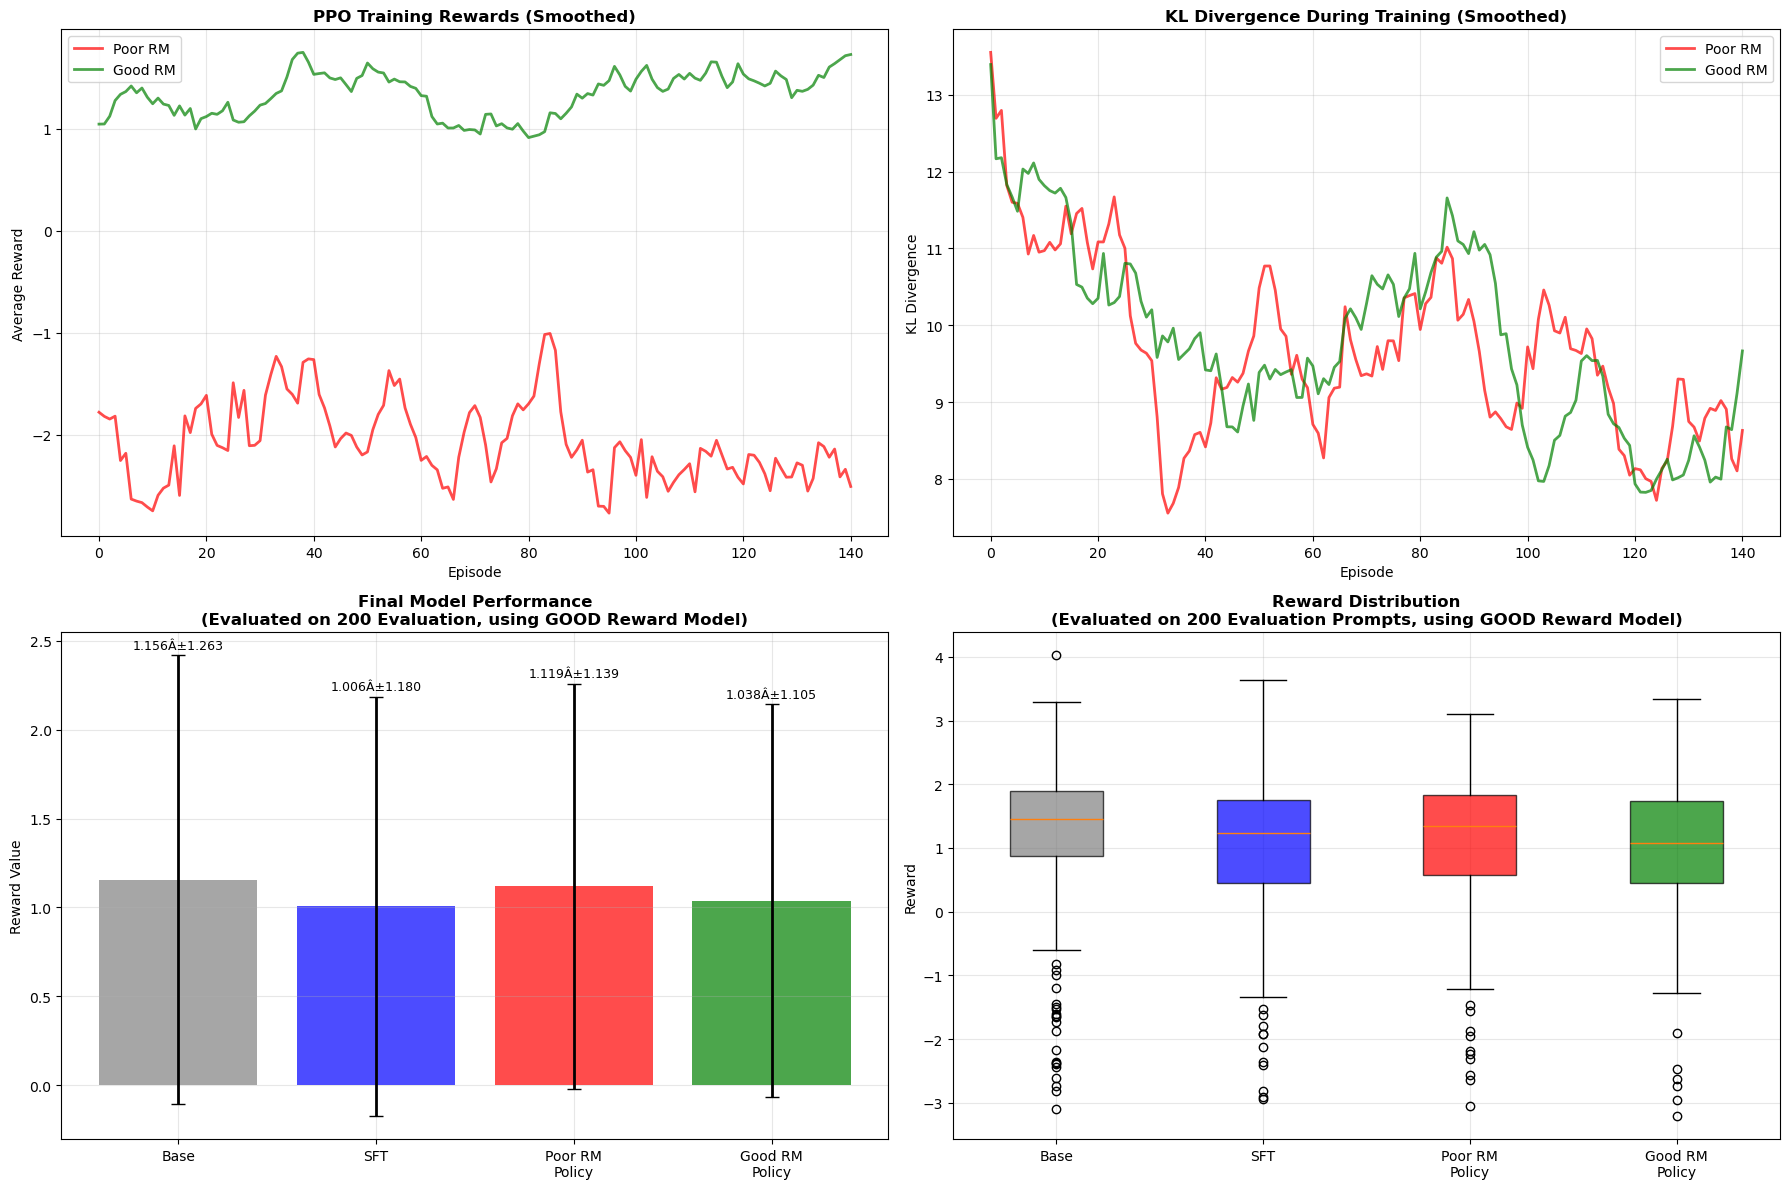

In [32]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12)) # Changed to 2x2 grid

# 1. Training rewards comparison (with smoothing)
window = 10
def smooth(data, window_size=window):
    if len(data) < window_size:
        return data
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

if len(poor_rewards) > window:
    smooth_poor = smooth(poor_rewards)
    smooth_good = smooth(good_rewards)

    axes[0, 0].plot(smooth_poor, label='Poor RM', color='red', alpha=0.7, linewidth=2)
    axes[0, 0].plot(smooth_good, label='Good RM', color='green', alpha=0.7, linewidth=2)
    axes[0, 0].set_title('PPO Training Rewards (Smoothed)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Average Reward')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

# 2. KL divergence during training
if len(poor_kls) > window:
    smooth_poor_kl = smooth(poor_kls)
    smooth_good_kl = smooth(good_kls)

    axes[0, 1].plot(smooth_poor_kl, label='Poor RM', color='red', alpha=0.7, linewidth=2)
    axes[0, 1].plot(smooth_good_kl, label='Good RM', color='green', alpha=0.7, linewidth=2)
    axes[0, 1].set_title('KL Divergence During Training (Smoothed)', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('KL Divergence')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

# 3. Final performance comparison on FULL EVALUATION SET (now axes[1,0])
final_scores = [base_results['mean'], sft_results['mean'], poor_results['mean'], good_results['mean']]
score_stds = [base_results['std'], sft_results['std'], poor_results['std'], good_results['std']]
labels = ['Base', 'SFT', 'Poor RM\nPolicy', 'Good RM\nPolicy']
colors = ['gray', 'blue', 'red', 'green']

x_pos = np.arange(len(labels))
bars = axes[1, 0].bar(x_pos, final_scores, yerr=score_stds,
                      color=colors, alpha=0.7, capsize=5, error_kw={'elinewidth': 2})
axes[1, 0].set_title(f'Final Model Performance\n(Evaluated on {len(evaluation_prompts)} Evaluation, using GOOD Reward Model)',
                     fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Average Reward')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(labels)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 0].set_ylabel('Reward Value') # Kept this as it clarifies the y-axis for the bar chart.
axes[1, 0].grid(True, alpha=0.3)

# Add mean and std annotations
for i, (bar, score, std) in enumerate(zip(bars, final_scores, score_stds)):
    height = bar.get_height()
    axes[1, 0].text(i, height + std + 0.02, f'{score:.3f}\u00c2\u00b1{std:.3f}',
                    ha='center', va='bottom', fontsize=9)

# 4. Reward distribution boxplot (now axes[1,1])
all_rewards = [
    base_results['all_rewards'],
    sft_results['all_rewards'],
    poor_results['all_rewards'],
    good_results['all_rewards']
]
bp = axes[1, 1].boxplot(all_rewards, tick_labels=labels, patch_artist=True)
colors_box = ['gray', 'blue', 'red', 'green']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 1].set_title(f'Reward Distribution\n(Evaluated on {len(evaluation_prompts)} Evaluation Prompts, using GOOD Reward Model)',
                     fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Reward')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## **(*) TODO 15**
## Part 9: Evaluation using the HELD-OUT test prompts

Make up three (3) additional prompts by yourself.  Present each one to all four models (base, sft, poorRM, goodRM) and show the outputs.

In [33]:
test_prompts = [
    "What are the benefits of regular exercise?",
    "Describe how computers store information",
    "Explain longevity:",
]

def generate_and_display(prompt, model, model_name, max_tokens=128):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            do_sample=True,
            temperature=0.7,
            pad_token_id=tokenizer.pad_token_id
        )
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    response = response[len(prompt):].strip()
    print(f"  [{model_name}]: {response[:200]}")

models = {
    "Base Model": base_model,
    "SFT Model": sft_model_eval,
    "Poor RM Policy": ppo_poor.policy,
    "Good RM Policy": ppo_good.policy,
}

for prompt in test_prompts:
    print(f"\nPrompt: \"{prompt}\"")
    print("-" * 60)
    for name, model in models.items():
        model.eval()
        generate_and_display(prompt, model, name)


Prompt: "What are the benefits of regular exercise?"
------------------------------------------------------------
  [Base Model]: There are several benefits. Some of them are:

Increased sensitivity to pain.

Increased sensitivity to stress.

Increased sensitivity to changes in blood pressure.

Increased sensitivity to heart rat
  [SFT Model]: Context: 
Response: Exercise does not adversely affect your health and well-being.
  [Poor RM Policy]: Regular exercise promotes health and fitness, improves memory, improves cognitive function, improves memory, and improves performance in school, sports, and social situations.
Regular exercise reduces
  [Good RM Policy]: Regular exercise improves performance, improves lifestyle and improves sleep. Regular exercise also reduces stress and improves quality of life.

Regular exercise improves performance, improves lifest

Prompt: "Describe how computers store information"
------------------------------------------------------------
  [Base Model]: